## Read Data (replies excluded)

In [1]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text = pd.read_csv('Jan6(excludes replies).csv')
print('The number of tweets (excludes replies):',len(text))

The number of tweets (excludes replies): 6501


## Data Cleaning

In [2]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
stop_words += ['rt']
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split():
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = words.lower()# lower form
                        words = re.sub(r'[^a-zA-Z]', ' ', words) #replace non-alphabets characters with space. From "can't" to "can t"
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >1:
            if token not in stop_words:
                token = porter.stem(token) #root form
                doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]

# exclude tweets that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','temiz','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','mayo','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text.drop(text.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text))

number of tweets after cleaning: 6230


In [3]:
text

,Unnamed: 0,tweets,date,Company,url,processed
0,0,"RT: To start off last year, in January 2020, @...",2021-01-05 15:59:55,Memphis Meats,https://twitter.com/MemphisMeats/status/134648...,start last year januari becam first cellbasedm...
1,1,Happy New Year from Memphis Meats! We’re closi...,2020-12-30 23:14:26,Memphis Meats,https://twitter.com/MemphisMeats/status/134442...,happi new year memphi meat close gratitud team...
2,2,"In these unprecedented times, we are devoting ...",2020-12-23 19:00:56,Memphis Meats,https://twitter.com/MemphisMeats/status/134182...,unpreced time devot attent brighter futur cell...
3,4,We chatted with @FoodDive on what’s happening ...,2020-12-16 21:26:40,Memphis Meats,https://twitter.com/MemphisMeats/status/133932...,chat happen cellular agricultur
4,5,From climate chaos to climate transformation? ...,2020-12-15 20:16:03,Memphis Meats,https://twitter.com/MemphisMeats/status/133894...,climat chao climat transform proud name cleant...
...,...,...,...,...,...,...
6494,7934,We're a growing team on an enormously exciting...,2019-09-27 04:00:29,Vow,https://twitter.com/vowfood/status/11774327967...,grow team enorm excit mission join team make r...
6495,7936,"Next week in Melbourne, our CCO Tim will be sp...",2019-08-28 02:18:29,Vow,https://twitter.com/vowfood/status/11665354944...,next week melbourn cco tim speak futur altern ...
6496,7937,RT: Shout out to @vowfood - founders @peppsyd ...,2019-08-15 18:49:46,Vow,https://twitter.com/vowfood/status/11620739148...,shout founder featur last week plate dumpl mad...
6498,7939,I'm attending Cellular Agriculture: End of the...,2020-11-18 14:17:37,LabFarmFoods,https://twitter.com/LabFarmFoods/status/132906...,attend cellular agricultur end year summit thi...


## GuidedLDA

In [4]:
import guidedlda
import numpy as np
seed_topic_list = [['environ','carbon','greenhous','emiss','better','planet','save','reduc',
                   'system','futur','land','plastic','sustain','climat'], #0 Environmental Impact
                   ['plant','vegan','vegetarian','anim','altern','protein'], #1 Vegetarian
                   ['without','harm','slaughter','cruelti','welfar','kill','cow','human','farm','save','free'],#2 Animal Welfare
                   ['consumpt','popul','demand','secur','wast','grow','global','sustain','need',
                   'consum','eat','growth','feed','solut'],#3 Food Security
                   ['antibiot','antimicrobi','resist','safe','contamin','free','health','overus',
                   'diseas','use','metal','bacteria'],#4 Food Safety
                   ['regulatori','usda','fda','safe','joint','label'],#5 Regulations
                   ['covid','pandem','risk','coronaviru'],# 6 COVID-19 Pandemic
                   ['industri','suppli','convent','system','chain','compani',
                    'market','consum','store','groceri','product','demand','grow','launch','scale','cost','sell'],#7 Food Industry & Market
                   ['seafood','ocean','fish','aquacultur','shrimp','salmon','wild','lobster','tuna','sushi','crustacean'],#8 Seafood
                   ['chicken','duck','poultri','burger','steak','meatbal','beef','sausag',
                    'tast','tender','textur','juici','test','delici','culinari','favorit','tasti'],#9 Poultry and Meat
                   ['stem','muscl','divis','biolog','cellular','technolog','agricultur','creat','made','biotech','tech'],#10 Process
                   ['seri','fund','rais','invest','dollar','pound','round','startup',
                   'opportun','first','seed','isra','acceler','announc','happi','thrill','excit','pleas','contribut','honor','proud','statement'], #11 Fundraising Announcement
                   ['thank','support','shoutout','help','question','mention'], #12 Appreciation
                   ['confer','regist','live','symposium','stream','livestream','summit','founder','talk','speak','ceo','tomorrow'], #13 Conference and Summit
                   ['hire','join','team','bring','welcom','work','appli','research','specialist','student','career','posit'],#14 Hiring Information
                   ['congrat','congratul','list','award','winner','finalist','partner','prize'],#15 Congratulations
                   ['check','post','paper','interview','articl','blog','news','break','read',
                   'latest','watch','podcast','listen','episod','stori','coverag','campaign','video','singapor','discuss','vote','panel',
                    'chat','report','ceo','media','present']]#16 Media

from sklearn.feature_extraction.text import CountVectorizer
model = guidedlda.GuidedLDA(n_topics=19,n_iter=1000,random_state=1,refresh=10,alpha=0.01,eta=0.01)
vectorizer = CountVectorizer(min_df =1 )
X = vectorizer.fit_transform(text['processed'])

vocab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.4) #set seed confidence to 0.4
topic_word = model.topic_word_
n_top_words = 30
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word):
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ')
        

INFO:guidedlda:n_documents: 6230
INFO:guidedlda:vocab_size: 7511
INFO:guidedlda:n_words: 75115
INFO:guidedlda:n_topics: 19
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -1031843
INFO:guidedlda:<10> log likelihood: -633653
INFO:guidedlda:<20> log likelihood: -616088
INFO:guidedlda:<30> log likelihood: -607953
INFO:guidedlda:<40> log likelihood: -602510
INFO:guidedlda:<50> log likelihood: -599537
INFO:guidedlda:<60> log likelihood: -597270
INFO:guidedlda:<70> log likelihood: -595498
INFO:guidedlda:<80> log likelihood: -594352
INFO:guidedlda:<90> log likelihood: -593201
INFO:guidedlda:<100> log likelihood: -592139
INFO:guidedlda:<110> log likelihood: -591646
INFO:guidedlda:<120> log likelihood: -591093
INFO:guidedlda:<130> log likelihood: -590262
INFO:guidedlda:<140> log likelihood: -588907
INFO:guidedlda:<150> log likelihood: -589031
INFO:guidedlda:<160> log likelihood: -588440
INFO:guidedlda:<170> log likelihood: -588014
INFO:guidedlda:<180> log likelihood: -587937
INFO



Topic: 0
0.0314*food  0.0261*meat  0.0235*chang  0.0231*climat  0.0165*sustain  0.0135*anim  0.0111*environment  0.0111*impact  0.0103*system  0.0103*product  0.0094*world  0.0088*global  0.0086*human  0.0081*reduc  0.0079*emiss  0.0075*agricultur  0.0071*environ  0.0071*way  0.0066*health  0.0062*eat  0.0058*need  0.0058*earth  0.0058*use  0.0056*industri  0.0056*less  0.0053*could  0.0053*solv  0.0053*solut  0.0053*water  0.0053*resourc  

Topic: 1
0.0475*meat  0.039*plant  0.0388*base  0.0248*protein  0.0174*year  0.0151*market  0.0146*plantbas  0.0135*burger  0.0131*altern  0.0126*industri  0.0122*vegan  0.0117*food  0.0101*product  0.0092*beyond  0.0086*new  0.0079*invest  0.0072*next  0.007*milk  0.0065*dairi  0.0065*consum  0.0063*report  0.0061*sale  0.0059*egg  0.0054*anim  0.0054*billion  0.0054*could  0.0054*say  0.0054*demand  0.0052*like  0.005*two  

Topic: 2
0.0964*meat  0.0523*anim  0.0271*without  0.0213*make  0.0165*futur  0.0156*real  0.0147*clean  0.0141*world  0.

## Categorize Tweets according to their most salient topic

In [5]:
doc_topic = model.transform(X)
topic_number = []
number = []

for i in range(len(doc_topic)):
    topic_number.append(doc_topic[i].argmax())
    number.append('1')
data = pd.DataFrame(data=[i for i in topic_number],columns=['topic_number'])
data['number'] = [i for i in number]
number_of_tweets = pd.DataFrame(data.groupby('topic_number')['number'].count())
#proportion = [i/len(text) for i in number_of_tweets['number']]
number_of_tweets['proportion'] = [str(round(i/len(text)*100,2))+'%' for i in number_of_tweets['number']]
number_of_tweets
        
    

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


,number,proportion
topic_number,,
0,326,5.23%
1,333,5.35%
2,567,9.1%
3,325,5.22%
4,196,3.15%
5,221,3.55%
6,231,3.71%
7,342,5.49%
8,183,2.94%


## Prominent factor

In [6]:
prominent_factor = []
for i in range(len(doc_topic)):
    prominent_factor.append(sorted(doc_topic[i])[-1]/sorted(doc_topic[i])[-2])
count = 0
for i in prominent_factor:
    if i >= 1.4:
        count += 1
print('Prominent factor:',round(count/len(text)*100,2),'%',sep='')

Prominent factor:80.3%


## Topic-Author Analysis

In [7]:
doc_topic = model.transform(X)
topic_number1 = []


for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text['topic number'] = [i for i in topic_number1]
topic_author = text.groupby(['topic number','Company'])['tweets'].count()
topic_author_3d = topic_author.unstack()
topic = ['Environmental Impact','Vegetarian and Alternative Protein','Animal Welfare',
        'Food Security', 'Food Safety', 'Regulations','COVID-19 Pandemic','Food Industry and Market',
         'Seafood','Poultry and Meat','Process','Announcement(fundraising)',
        'Appreciation','Conference and Summit','Hiring Informaiton','Congratulations',
        'Media','Unseeded Topic 1','Unseeded Topic 2']

company = ['Aleph Farms','Avant Meats','Balletic Foods','BlueNalu','Cubiq Foods',
           'Fineless Foods','Future Fields','FutureMeat','LabFarmFoods','Meatable','Memphis Meats',
          'Mission Barns','Mosa Meat','New Age Meats','SuperMeat','Vow','Wildtype',
          'biftek.co','Shiokmeats']

topic_author_3d

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


Company,Aleph Farms,Avant Meats,Balletic Foods,BlueNalu,CUBIQ FOODS,Finless Foods,Future Fields,FutureMeat,LabFarmFoods,Meatable,Memphis Meats,Mission Barns,Mosa Meat,New Age Meats,SuperMeat,Vow,Wildtype,biftek.co 🔬👩‍🔬🐄🥗,shiokmeats
topic number,,,,,,,,,,,,,,,,,,,
0,77.0,NaN,NaN,13.0,11.0,20.0,1.0,1.0,NaN,4.0,54.0,NaN,10.0,4.0,25.0,NaN,2.0,95.0,9.0
1,11.0,NaN,2.0,4.0,33.0,14.0,NaN,1.0,NaN,3.0,29.0,NaN,NaN,5.0,5.0,1.0,1.0,214.0,10.0
2,20.0,NaN,NaN,9.0,4.0,24.0,NaN,4.0,1.0,16.0,250.0,NaN,NaN,25.0,117.0,4.0,3.0,77.0,13.0
3,26.0,NaN,2.0,49.0,17.0,28.0,3.0,2.0,NaN,1.0,76.0,NaN,3.0,9.0,14.0,NaN,6.0,73.0,16.0
4,6.0,NaN,NaN,11.0,8.0,39.0,NaN,NaN,NaN,3.0,19.0,NaN,1.0,2.0,4.0,NaN,2.0,81.0,20.0
5,12.0,NaN,1.0,11.0,3.0,23.0,NaN,NaN,NaN,6.0,55.0,NaN,5.0,50.0,6.0,NaN,5.0,35.0,9.0
6,15.0,NaN,1.0,4.0,14.0,22.0,4.0,NaN,1.0,1.0,44.0,NaN,NaN,7.0,19.0,NaN,2.0,89.0,8.0
7,44.0,1.0,NaN,31.0,13.0,16.0,6.0,4.0,NaN,11.0,57.0,NaN,7.0,6.0,6.0,3.0,3.0,112.0,22.0
8,2.0,NaN,NaN,29.0,NaN,42.0,NaN,1.0,NaN,NaN,6.0,NaN,1.0,1.0,2.0,NaN,26.0,28.0,45.0


## Topic-Author Distribution Heatmap (based on raw counts)

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(topic_author_3d,cmap="Blues")
plt.colorbar()
plt.xticks(range(len(topic_author_3d)), company,rotation=90)
plt.yticks(range(len(topic_author_3d)), topic)
plt.show()

<Figure size 1000x800 with 2 Axes>

## Heatmap based on proportion of each topic for each company

In [9]:
topic_author_3d = topic_author_3d.fillna(0) #replace NaN by 0

In [10]:
topic_author_3d

Company,Aleph Farms,Avant Meats,Balletic Foods,BlueNalu,CUBIQ FOODS,Finless Foods,Future Fields,FutureMeat,LabFarmFoods,Meatable,Memphis Meats,Mission Barns,Mosa Meat,New Age Meats,SuperMeat,Vow,Wildtype,biftek.co 🔬👩‍🔬🐄🥗,shiokmeats
topic number,,,,,,,,,,,,,,,,,,,
0,77.0,0.0,0.0,13.0,11.0,20.0,1.0,1.0,0.0,4.0,54.0,0.0,10.0,4.0,25.0,0.0,2.0,95.0,9.0
1,11.0,0.0,2.0,4.0,33.0,14.0,0.0,1.0,0.0,3.0,29.0,0.0,0.0,5.0,5.0,1.0,1.0,214.0,10.0
2,20.0,0.0,0.0,9.0,4.0,24.0,0.0,4.0,1.0,16.0,250.0,0.0,0.0,25.0,117.0,4.0,3.0,77.0,13.0
3,26.0,0.0,2.0,49.0,17.0,28.0,3.0,2.0,0.0,1.0,76.0,0.0,3.0,9.0,14.0,0.0,6.0,73.0,16.0
4,6.0,0.0,0.0,11.0,8.0,39.0,0.0,0.0,0.0,3.0,19.0,0.0,1.0,2.0,4.0,0.0,2.0,81.0,20.0
5,12.0,0.0,1.0,11.0,3.0,23.0,0.0,0.0,0.0,6.0,55.0,0.0,5.0,50.0,6.0,0.0,5.0,35.0,9.0
6,15.0,0.0,1.0,4.0,14.0,22.0,4.0,0.0,1.0,1.0,44.0,0.0,0.0,7.0,19.0,0.0,2.0,89.0,8.0
7,44.0,1.0,0.0,31.0,13.0,16.0,6.0,4.0,0.0,11.0,57.0,0.0,7.0,6.0,6.0,3.0,3.0,112.0,22.0
8,2.0,0.0,0.0,29.0,0.0,42.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0,0.0,26.0,28.0,45.0


In [11]:
topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Company,Aleph Farms,Avant Meats,Balletic Foods,BlueNalu,CUBIQ FOODS,Finless Foods,Future Fields,FutureMeat,LabFarmFoods,Meatable,Memphis Meats,Mission Barns,Mosa Meat,New Age Meats,SuperMeat,Vow,Wildtype,biftek.co 🔬👩‍🔬🐄🥗,shiokmeats
topic number,,,,,,,,,,,,,,,,,,,
0,0.109687,0.0,0.00,0.047794,0.045455,0.038986,0.022727,0.03125,0.0,0.035088,0.034929,0.0,0.092593,0.013072,0.079114,0.000000,0.022472,0.067090,0.019438
1,0.015670,0.0,0.08,0.014706,0.136364,0.027290,0.000000,0.03125,0.0,0.026316,0.018758,0.0,0.000000,0.016340,0.015823,0.027778,0.011236,0.151130,0.021598
2,0.028490,0.0,0.00,0.033088,0.016529,0.046784,0.000000,0.12500,0.5,0.140351,0.161708,0.0,0.000000,0.081699,0.370253,0.111111,0.033708,0.054379,0.028078
3,0.037037,0.0,0.08,0.180147,0.070248,0.054581,0.068182,0.06250,0.0,0.008772,0.049159,0.0,0.027778,0.029412,0.044304,0.000000,0.067416,0.051554,0.034557
4,0.008547,0.0,0.00,0.040441,0.033058,0.076023,0.000000,0.00000,0.0,0.026316,0.012290,0.0,0.009259,0.006536,0.012658,0.000000,0.022472,0.057203,0.043197
5,0.017094,0.0,0.04,0.040441,0.012397,0.044834,0.000000,0.00000,0.0,0.052632,0.035576,0.0,0.046296,0.163399,0.018987,0.000000,0.056180,0.024718,0.019438
6,0.021368,0.0,0.04,0.014706,0.057851,0.042885,0.090909,0.00000,0.5,0.008772,0.028461,0.0,0.000000,0.022876,0.060127,0.000000,0.022472,0.062853,0.017279
7,0.062678,0.5,0.00,0.113971,0.053719,0.031189,0.136364,0.12500,0.0,0.096491,0.036869,0.0,0.064815,0.019608,0.018987,0.083333,0.033708,0.079096,0.047516
8,0.002849,0.0,0.00,0.106618,0.000000,0.081871,0.000000,0.03125,0.0,0.000000,0.003881,0.0,0.009259,0.003268,0.006329,0.000000,0.292135,0.019774,0.097192


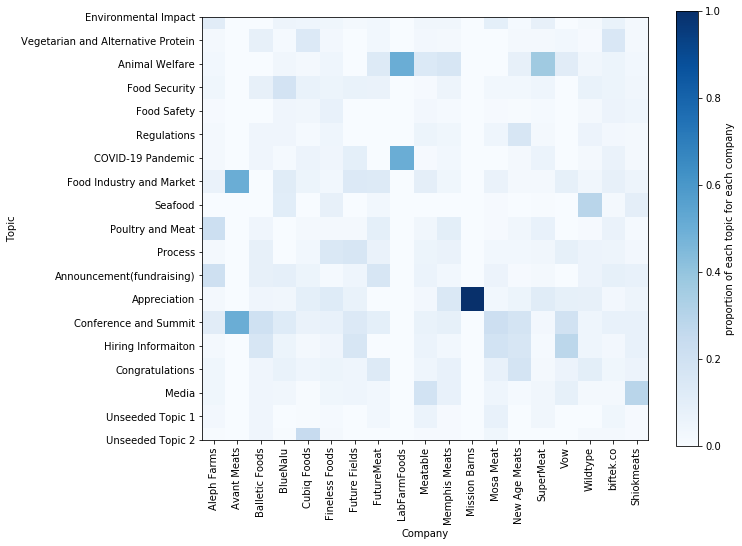

In [12]:
plt.figure(figsize=(10,8))
plt.imshow(topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1),cmap="Blues")
plt.colorbar().ax.set_ylabel('proportion of each topic for each company')
plt.xticks(range(len(topic_author_3d)), company,rotation=90)
plt.yticks(range(len(topic_author_3d)), topic)
plt.xlabel('Company')
plt.ylabel('Topic')
plt.show()

## PyLDAvis Visualization

In [13]:
import pyLDAvis
import pyLDAvis.sklearn
data = pyLDAvis.sklearn.prepare(model, X, vectorizer)

pyLDAvis.display(data)

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### This visualization seems not to match the results in guidedLDA. The index of topics in this visualization was different from the index of the topics in guidedLDA.
